# Full BERT

## Imports

In [1]:
## for data
import pandas as pd
import numpy as np#

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

## read in data

In [2]:
### list of side effect

side_effects = pd.read_csv('../raw_data/frequent_adr.csv')

#side_effects.head(3)

### read in raw training data with ratings under 5

data = pd.read_csv('../raw_data/drugsComTrain_raw.csv')

data = data[data['rating'] < 5]
data = data.reset_index(drop = True)
data = data.sort_values(by=['drugName'])
data = data.reset_index(drop = True)
data = data.drop(["uniqueID", "date", "usefulCount"], axis = 1)
# print(pd.DataFrame(data["drugName"].value_counts()))

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40075 entries, 0 to 40074
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   drugName   40075 non-null  object
 1   condition  39828 non-null  object
 2   review     40075 non-null  object
 3   rating     40075 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [3]:
data.tail()

,drugName,condition,review,rating
40070,ella,Emergency Contraception,"""I had unprotected sex on the 17th this month ...",1
40071,ella,Emergency Contraception,"""Took ella 2 days after unprotected sex ..3 da...",1
40072,ella,Emergency Contraception,"""I took Ellaone like end of oct time on the sa...",4
40073,femhrt,Acne,"""Recently switched from birth conrtol which ke...",1
40074,femhrt,0</span> users found this comment helpful.,"""I was on femHRT for four months and had BV (b...",1


## Preprocessing

In [4]:
### define preprocessing utlities function

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [5]:
### download stopwords

lst_stopwords = nltk.corpus.stopwords.words("english")

In [6]:
### creat cleaned text column

data["review_clean"] = data["review"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

data.head()

,drugName,condition,review,rating,review_clean
0,Abacavir / dolutegravir / lamivudine,HIV Infection,"""I switched to this med because my last med pu...",4,switched med last med put horrible fog atripla...
1,Abacavir / dolutegravir / lamivudine,HIV Infection,"""I have had HIV since Nov.2002 I was taking Vi...",4,hiv since nov2002 taking viread triziver docto...
2,Abacavir / dolutegravir / lamivudine,HIV Infection,"""Diagnosed 5 years ago been on truvada and ise...",3,diagnosed 5 year ago truvada isentress problem...
3,Abacavir / dolutegravir / lamivudine,HIV Infection,"""After taking complera for 5 years, switched t...",4,taking complera 5 year switched triumec lil mo...
4,Abacavir / dolutegravir / lamivudine,HIV Infection,"""Started on Triumeq exactly 1 month. Trying to...",3,started triumeq exactly 1 month trying underst...


In [7]:
## make side effects in to a single list of strings

side_effects_lofl = side_effects.values.tolist()
side_effects_lofl
side_effects_list = list(map(''.join, side_effects_lofl)) 
#map(lambda x:x.lower(),side_effects_list)
[x.lower() for x in side_effects_list]
print(side_effects_list)

['Abdominal pain', 'Gastrointestinal pain', 'Amblyopia', 'Anaemia', 'Anorexia', 'Decreased appetite', 'Asthenia', 'Atrial fibrillation', 'Back pain', 'Cardiovascular disorder', 'Chest pain', 'Infection', 'Constipation', 'Cough', 'Depression', 'Diarrhoea', 'Dizziness', 'Dysgeusia', 'Dyspepsia', 'Dyspnoea', 'Eye disorder', 'Body temperature increased', 'Gastrointestinal disorder', 'Headache', 'Haemorrhage', 'Haemoglobin', 'Hypercalcaemia', 'Hyperkalaemia', 'Hypersensitivity', 'Hypertension', 'Hypotension', 'Influenza', 'Cramps of lower extremities', 'Muscle spasms', 'Melaena', 'Nausea', 'Pain', 'Palpitations', 'Parathyroid disorder', 'Paraesthesia', 'Pharyngitis', 'Pruritus', 'Renal failure', 'Rhinitis', 'Tachycardia', 'Urinary tract infection', 'Angiopathy', 'Vertigo', 'Vomiting', 'Weight increased', 'Weight decreased', 'Oedema peripheral', 'Injection site reaction', 'Accidental injury', 'Injury', 'Myalgia', 'Musculoskeletal discomfort', 'Electrocardiogram abnormal', 'Fluid overload', '

### create a dictionary with side effects

In [8]:
## get pretrained word-embedding model
nlp = gensim_api.load("glove-wiki-gigaword-200")

In [21]:
nlp.most_similar(["experiencing"], topn=30)

AttributeError: 'TFBertModel' object has no attribute 'most_similar'

In [10]:
## Function to apply

def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

## Create Dictionary {category:[keywords]}
dic_clusters = {}

dic_clusters["SIDE_EFFECTS"] = get_similar_words(['nausea', 'headache', 'fatigue', 'reaction', 'cramps'], 
                  top=50, nlp=nlp)

dic_clusters["NO_SIDE_EFFECTS"] = get_similar_words(['heal', 'improvement', 'worked', 'change'], 
                  top=50, nlp=nlp)

## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

SIDE_EFFECTS :  ['diarrhea', 'symptoms', 'anxiety', 'complaining', 'debilitating'] ... 55
NO_SIDE_EFFECTS :  ['to', 'time', 'work', 'improvement', 'could'] ... 54


In [12]:
dic_clusters_df = get_similar_words(['nausea', 'headache', 'fatigue', 'reaction', 'cramps', 'depression'], 
                  top=200, nlp=nlp)

side_effect_similar_words = pd.DataFrame.from_dict(dic_clusters_df) 

side_effect_similar_words.head(50)
   

,0
0,resulting
1,boredom
2,complaining
3,lightheadedness
4,delirium
5,disturbances
6,bloating
7,mild
8,effects
9,itching


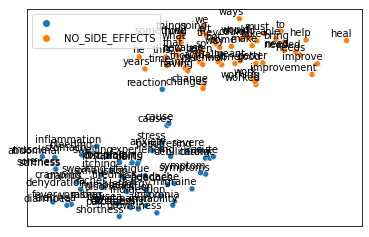

In [13]:
### graph side effecs

## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]

## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)

## plot
fig, ax = plt.subplots()
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)

ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])

for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

## Feature Engineering

In [14]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
txt = "side effect"

## tokenize
idx = tokenizer.encode(txt)
print("tokens:", tokenizer.convert_ids_to_tokens(idx))
print("ids   :", tokenizer.encode(txt))## word embedding
idx = np.array(idx)[None,:]
embedding = nlp(idx)
print("shape:", embedding[0][0].shape)## vector of the second input word
embedding[0][0][2]

tokens: ['[CLS]', 'side', 'effect', '[SEP]']
ids   : [101, 2217, 3466, 102]
shape: (4, 768)


<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([-1.90451011e-01, -7.59310722e-01, -2.77373761e-01, -3.19249123e-01,
        1.74799487e-01,  3.63088042e-01,  3.13944161e-01,  6.43611312e-01,
       -6.33405209e-01, -3.43395889e-01,  5.73204577e-01, -7.70332366e-02,
        6.06797099e-01,  5.90676010e-01, -1.20192730e+00,  1.91419646e-01,
        3.99864405e-01,  1.65890455e-02, -1.01072669e-01,  2.98030198e-01,
        3.92783105e-01,  4.62260485e-01, -1.06343591e+00,  8.60917449e-01,
       -8.28085169e-02, -1.91051364e-02, -5.58272719e-01,  3.02554369e-01,
       -3.12645704e-01, -1.31799734e+00,  6.35154247e-01,  1.62343696e-01,
       -9.89773721e-02, -2.86189944e-01, -5.65773606e-01, -4.10185158e-01,
        3.59669030e-02, -1.24057837e-01, -3.66839945e-01,  5.33981681e-01,
       -7.47704983e-01, -8.19939137e-01,  9.45937812e-01,  1.35194540e-01,
        3.10625017e-01, -1.97726294e-01,  9.08305645e-01,  4.00246501e-01,
        1.04596190e-01, -6.31183833e-02,  5.66941723

In [16]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    X = np.array(embedding[0][0][1:-1])
    return X

## create list of side effect vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) 
                 for txt in data["review_clean"]]

## create the feature matrix (n side effects x 768)
X = np.array(lst_mean_vecs)

Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors


InvalidArgumentError: indices[0,513] = 513 is not in [0, 512) [Op:ResourceGather]

In [ ]:
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v
         in dic_clusters.items()}

## Compute Cosine similarties

In [ ]:
#--- Model Algorithm ---### compute cosine similarities
similarities = np.array(
            [metrics.pairwise.cosine_similarity(X, y).T.tolist()[0] 
             for y in dic_y.values()]
            ).T

## adjust and rescale
labels = list(dic_y.keys())
for i in range(len(similarities)):    
    
### assign randomly if there is no similarity
    if sum(similarities[i]) == 0:
       similarities[i] = [0]*len(labels)
       similarities[i][np.random.choice(range(len(labels)))] = 1    
        
        ### rescale so they sum = 1
    similarities[i] = similarities[i] / sum(similarities[i])

    ## classify the label with highest similarity score
predicted_prob = similarities
predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

# Distil Bert (lighter model) (load prior preprocessing)

In [ ]:
### tranformer and tokenizer

txt = "side effect"

## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

## return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]  
embedding = nlp(input_ids)
embedding[0][0]

In [ ]:
### Distilled BERT tokenizer

In [ ]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [ ]:
corpus = data["review_clean"]
maxlen = 50
## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
    
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [ ]:
i = 0print("txt: ", data["review_clean"].iloc[0])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")

## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = Falsenlp = transformers.TFDistilBertModel.from_pretrained('distilbert-
                  base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
                                                                                        
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)## compile
model = models.Model([idx, masks], y_out)for layer in model.layers[:3]:
    layer.trainable = Falsemodel.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])model.summary()

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

## train
training = model.fit(x=X_train, y=y_train, batch_size=64, 
                     epochs=1, shuffle=True, verbose=1, 
                     validation_split=0.3)

## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]